**Homework_2 solution**

* Student: Egri Dávid, ASLG76

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import copy
import matplotlib.pyplot as plt

%matplotlib notebook
plt.style.use('seaborn-darkgrid')

# My solution

* I modified the learn() function and the MLP class too

* There ara some modification outside the # HF2 start .. - # HF2 stop .. comment lines too

In [2]:
def activation(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def dactivation(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

In [4]:
# MLP osztály létrehozása.
class MLP:
    
    # A hálózat inicializálása az argumentumként megadott méretek alapján.
    def __init__(self, *args):
        # random seed megadása
        np.random.seed(123)
        # A hálózat formája (rétegek száma), amely megegyezik a paraméterek számával
        self.shape = args
        n = len(args)
        # Rétegek létrehozása
        self.layers = []
        # Bemeneti réteg létrehozása (+1 egység a BIAS-nak)
        self.layers.append(np.ones(self.shape[0]+1))
        # Rejtett réteg(ek) és a kimeneti réteg létrehozása
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        # Súlymátrix létrehozása
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))
        # dw fogja tartalmazni a súlyok utolsó módosításait (később pl. a momentum módszer számára)
        self.dw = [0,]*len(self.weights)
        # Súlyok újrainicializálása
        self.reset()

    # Súlyok újrainicializálási függvényének definiálása
    def reset(self):
        for i in range(len(self.weights)):
            # véletlen számok [0,1) tartományban 
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            # átskálázzuk a súlyokat -1..1 tartományba
            self.weights[i][...] = (2*Z-1)*1

    # A bemenő adatok végigküldése a hálózaton, kimeneti rétegig (forward propagation)
    def propagate_forward(self, data):
        # Bemeneti réteg beállítása (tanító adatok)
        self.layers[0][0:-1] = data
        # Az adatok végigküldése a bemeneti rétegtől az utolsó előtti rétegig (az utolsó ugyanis a kimeneti réteg).
        # A szigmoid aktivációs függvény használatával, mátrixszorzások alkalmazásával.
        # Az előadáson a "layers" változót jelöltük "a"-val.
        for i in range(1,len(self.shape)):
            self.layers[i][...] = activation(np.dot(self.layers[i-1],self.weights[i-1]))
        # Visszatérés a hálózat által becsült eredménnyel
        return self.layers[-1]

    # Hibavisszaterjesztés (backpropagation) definiálása. 
    # A a learning rate (tanulási ráta) paraméter befolyásolja, hogy a hálózat súlyait milyen
    # mértékben módosítsuk a gradiens függvényében. Ha ez az érték túl magas, akkor a háló 
    # "oszcillálhat" egy lokális vagy globális minimum körül. Ha túl kicsi értéket választunk,
    # akkor pedig jelentősen több időbe telik mire elérjük a legjobb megoldást vagy leakad egy lokális 
    # minimumban és sose éri el azt.
    
    def propagate_backward(self, target, lrate=0.1):
        deltas = []
        # Hiba kiszámítása a kimeneti rétegen
        error = -(target-self.layers[-1]) # y-y_kalap
        # error*dactivation(s(3))
        delta = np.multiply(error,dactivation(np.dot(self.layers[-2],self.weights[-1])))
        deltas.append(delta)
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2,0,-1):
            # pl. utolsó rejtett réteg: delta(3)*(W(2).T)*dactivation(s(2)) (lásd előadás)
            delta=np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1],self.weights[i-1]))
            deltas.insert(0,delta)            
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            # pl. utolsó rétegben: delta(3)*a(2) (lásd előadás)
            dw = -lrate*np.dot(layer.T,delta)
           
            # súlyok módosítása
            '''
            uncomment because of the mini batch
            self.weights[i] += dw 
            '''
            
            # a súlymódosítás eltárolása
            self.dw[i] = dw

        # Visszatérés a hibával
        return (error**2).sum()

In [37]:
def learn(network, X, Y, valid_split, test_split, epochs=100, lrate=0.1, momentum_constant = 0.9, L1_reg = True, L2_reg = False):

        # train-validation-test minták különválasztása
        X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
        Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
        X_valid = X[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        Y_valid = Y[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
        X_test  = X[int(nb_samples*(1-test_split)):]
        Y_test  = Y[int(nb_samples*(1-test_split)):]
    
        # standardizálás
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test  = scaler.transform(X_test)
    
        # ugyanolyan sorrendben keverjük be a bemeneteket és kimeneteket, a három külön adatbázisra
        randperm = np.random.permutation(len(X_train))
        X_train, Y_train = X_train[randperm], Y_train[randperm]
        randperm = np.random.permutation(len(X_valid))
        X_valid, Y_valid = X_valid[randperm], Y_valid[randperm]
        randperm = np.random.permutation(len(X_test))
        X_test, Y_test = X_test[randperm], Y_test[randperm]
        
        best_valid_err = np.inf
        es_counter = 0 # early stopping counter
        best_model = network
    
        # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
        for i in range(epochs):
            
            # Jelen megoldás azt a módszert használja, hogy a megadott 
            # tanító adatokon végigmegyünk és minden elemet először végigküldünk
            # a hálózaton, majd terjeszti vissza a kapott eltérést az
            # elvárt eredménytől. Ezt hívjuk SGD-ek (stochastic gradient descent).

            # ------------------------------------------------------------------
            # ---------------------- HF2 start mini-batch ----------------------
            # ------------------------------------------------------------------
            
            '''
            In the propagate backward function I deleted the 'self.weights[i] += dw' line
            because in the the mini batch case, it need to be done at the end of one mini-batch with
            the average weigth difference.
            '''
            
            # shufle the training data in every epoch
            randperm = np.random.permutation(len(X_train))
            X_train, Y_train = X_train[randperm], Y_train[randperm]
            
            # define mini batch size
            mini_batch_size = 16
            
            # set training error to zero at the start of one epoch
            train_err = 0
            
            # create the batches 
            batches = []
            for i in range(0, X_train.shape[0], mini_batch_size):
                batch = []
                batch.append(X_train[i:i+mini_batch_size])
                batch.append(Y_train[i:i+mini_batch_size])
                batches.append(batch)
            
            '''
            The batches variable:
            batches = [[X_train[first_minibatch], y_train[first_minibatch]], [X_train[second_minibatch], y_train[second_minibatch]], ... ]
            batches[0] --> the first batch
            batches[0][0] --> the X_train in the first batch
            batches[0][1] --> the Y_train in the first batch
            batches[0][0][i] --> the i'th elemnt in the X_train in the first batch
            '''
            
            '''
            for the HF2 momentum part --> set the previous weigth difference to zero for the first batch.
            The stucture of the previous_dw is simlar to the temp_dw variable which stores the 
            weigth differences in one batch
            '''
            previous_dw = []
            for i in range(batch[0].shape[0]):
                temp = []
                for j in range(len(network.shape)-1):
                    temp.append(np.zeros((network.layers[j].size,
                                          network.layers[j+1].size)))
                previous_dw.append(temp)
        
            # go through the batches
            for batch in batches: 
                # store the weigth differences in one batch
                temp_dw = []
                # store the train error for one batch
                temp_train_error = 0
                
                '''
                propagate forward and backward every train element in one batch 
                and store the weights differences but do not change the weights
                '''
                for i in range(batch[0].shape[0]):
                    network.propagate_forward(batch[0][i])
                    temp_train_error += network.propagate_backward(batch[1][i], lrate) # network.propagate_backward does not change the weights just calculate the difference
                    temp_dw.append(network.dw) # network.dw stores the calculated weight difference
                                
                # after the batch, change the weights with the avarage weight difference in one batch
                for dw in temp_dw:
                    for i in range(len(network.weights)):
                        network.weights[i] += dw[i]/len(batch) # divide with the length of the batch to get the avarage
               
                # ------------------------------------------------------------------
                # ---------------------- HF2 start momentum ------------------------
                # ------------------------------------------------------------------
                
                '''
                This is the momentum part of the weight modification
                I use the previous batch avarage dw values for the 
                previous weight difference
                
                The previous_dw was initialized before the " for batch in batches: " line
                '''
                
                for dw in previous_dw:
                    for i in range(len(network.weights)):
                        network.weights[i] += momentum_constant*dw[i]/len(batch)
                        
                previous_dw = temp_dw
                # ------------------------------------------------------------------
                # ---------------------- HF2 end momentum --------------------------
                # ------------------------------------------------------------------
                
                
                # ------------------------------------------------------------------
                # ---------------------- HF2 start l1reg ---------------------------
                # ------------------------------------------------------------------
                '''
                It was not clear for me that if I use L1 regularization with the momentum
                method than I should include the regularizatinon part in the previous wieght difference.
                Thus the previous_dw term should include the L1 regularization part.
                '''
                
                if L1_reg:
                    L1_reg_constant = 0.001
                    for i in range(len(network.weights)):
                        network.weights[i] -= lrate*L1_reg_constant*np.sign(network.weights[i])
                
                # ------------------------------------------------------------------
                # ---------------------- HF2 stop l1reg ----------------------------
                # ------------------------------------------------------------------

                
                # ------------------------------------------------------------------
                # ---------------------- HF2 start l2reg ---------------------------
                # ------------------------------------------------------------------
                '''
                It was not clear for me that if I use L2 regularization with the momentum
                method than I should include the regularizatinon part in the previous wieght difference.
                Thus the previous_dw term should include the L2 regularization part.
                '''
                
                if L2_reg:
                    L2_reg_constant = 0.001
                    for i in range(len(network.weights)):
                        network.weights[i] -= lrate*L2_reg_constant*network.weights[i]
                
                # ------------------------------------------------------------------
                # ---------------------- HF2 stop l2reg ----------------------------
                # ------------------------------------------------------------------
                
                        
                # avarage train error in one batch
                train_err += temp_train_error/len(batch)
            
            train_err /= X_train.shape[0]
            
            # ------------------------------------------------------------------
            # ---------------------- HF2 end mini-batch ------------------------
            # ------------------------------------------------------------------
            
            '''
            Comment the original SGD part:
            
            train_err = 0
            for k in range(X_train.shape[0]):
                network.propagate_forward( X_train[k] )
                train_err += network.propagate_backward( Y_train[k], lrate )
            train_err /= X_train.shape[0]
            '''

            # validációs fázis
            valid_err = 0
            o_valid = np.zeros(X_valid.shape[0])
            for k in range(X_valid.shape[0]):
                o_valid[k] = network.propagate_forward(X_valid[k])
                valid_err += (o_valid[k]-Y_valid[k])**2
            valid_err /= X_valid.shape[0]

            print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i, train_err, valid_err))

        # Tesztelési fázis
        print("\n--- TESZTELÉS ---\n")
        test_err = 0
        o_test = np.zeros(X_test.shape[0])
        for k in range(X_test.shape[0]):
            o_test[k] = network.propagate_forward(X_test[k])
            test_err += (o_test[k]-Y_test[k])**2
            print(k, X_test[k], '%.2f' % o_test[k], ' (elvart eredmeny: %.2f)' % Y_test[k])
        test_err /= X_test.shape[0]

        fig1=plt.figure()
        plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]), cmap=plt.cm.cool)

In [38]:
# Mesterséges neurális hálózat létrehozása, 2 bemenettel, 10 rejtett neuronnal és 1 kimenettel
network = MLP(2,10,1)

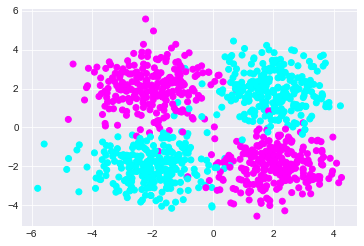

In [39]:
# Tanító, validációs és teszt adatok megadása a rendszernek (zajjal terhelt XOR adatok)
nb_samples=1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i], Y[i] = (-2+noise[0],-2+noise[1]), 0
    X[i+1], Y[i+1] = (2+noise[2],-2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],2+noise[5]), 1
    X[i+3], Y[i+3] = (2+noise[6],2+noise[7]), 0

# ...és az adatok kirajzolása
fig1=plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y[:], cmap=plt.cm.cool)

1 epoch, train_err: 0.1378, valid_err: 0.2480
1 epoch, train_err: 0.1335, valid_err: 0.2447
1 epoch, train_err: 0.1289, valid_err: 0.2977
1 epoch, train_err: 0.1288, valid_err: 0.2754
1 epoch, train_err: 0.1104, valid_err: 0.2022
1 epoch, train_err: 0.1004, valid_err: 0.1879
1 epoch, train_err: 0.0850, valid_err: 0.1545
1 epoch, train_err: 0.0794, valid_err: 0.1295
1 epoch, train_err: 0.0610, valid_err: 0.1407
1 epoch, train_err: 0.0520, valid_err: 0.0959
1 epoch, train_err: 0.0440, valid_err: 0.0871
1 epoch, train_err: 0.0426, valid_err: 0.0921
1 epoch, train_err: 0.0390, valid_err: 0.0721
1 epoch, train_err: 0.0381, valid_err: 0.0902
1 epoch, train_err: 0.0345, valid_err: 0.0653
1 epoch, train_err: 0.0436, valid_err: 0.0831
1 epoch, train_err: 0.0381, valid_err: 0.0721
1 epoch, train_err: 0.0331, valid_err: 0.0609
1 epoch, train_err: 0.0317, valid_err: 0.0538
1 epoch, train_err: 0.0278, valid_err: 0.0568
1 epoch, train_err: 0.0275, valid_err: 0.0556
1 epoch, train_err: 0.0278, valid_

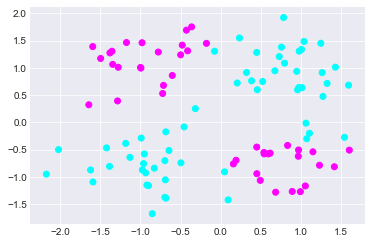

In [40]:
# Tanítás/Tesztelés indítása
network.reset()
learn(network, X, Y, 0.2, 0.1)